In [1]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import keras
import pyodbc
import numpy as np
import pandas as pd
from collections import Counter
from utils import *

In [2]:
# grunet_model = keras.models.load_model('models/bigru_model_v3.h5')

In [10]:
# connection parameters
server = '52.224.6.206' 
database = 'Previsora_SECOP' 
username = 'admin_usersql' 
password = 'admin_usersql'

cnxn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
#cursor = cnxn.cursor()

#Sample select query
query = "SELECT * FROM dbo.EntrenamientoSECOP"
df = pd.read_sql(query,cnxn)

# Erase rows with null values
df = df.loc[~df['ObjetoProceso'].isnull()]

# Erase rows where text length is less than 20
df = df.loc[df['ObjetoProceso'].apply(len) > 20]

# Separate label column and make lower case all text
text = df['ObjetoProceso']
#text = np.array([desc.lower() for desc in text])

# Spell checker and in-context correction
text_all_corrected = correct_words(text)
print(len(text_all_corrected))

y = df['Clasificacion'].astype(int).values
Counter(y)

Counter({1: 5047, 0: 1034})

In [3]:
n_classes = 2
maxLen = max([len(text.split(' ')) for text in text_all_corrected])
embedding_dim = 300

tokens = {word for sentence in text_all_corrected for word in sentence.split(' ')} - {''}
vocab = sorted(list(tokens))
num_tokens = len(vocab)
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for i, word in enumerate(vocab):
    embedding_matrix[i] = nlp(word).vector

In [4]:
X_inds = sentences_to_indices(text_all_corrected, vocab, maxLen)
del text, text_all_corrected, df

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score, confusion_matrix

def train_and_evaluate_keras_model(model, data_train, labels_train, data_test):    
    metrics = [
        'accuracy', 'Recall', 'Precision',
        keras.metrics.AUC(name='auc'),
        keras.metrics.AUC(name='prc', curve='PR')
        ]
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
    classes = dict(Counter(labels_train))
    total = len(labels_train)
    pos = classes[1]
    neg = classes[0]
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)
    class_weight = {0: weight_for_0, 1: weight_for_1}

    #Train model
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_recall', 
        patience=5,
        mode='max',
        restore_best_weights=True
        )
    X_train, X_val, y_train, y_val = train_test_split(data_train, labels_train, test_size=.1, random_state=42)
    model.fit(X_train, y_train, batch_size=128, epochs=100, validation_data = (X_val, y_val), 
    callbacks = [early_stop], class_weight=class_weight)    
    return (model.predict(data_test) > .5).astype(int)

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
  
acc_list = []
bacc_list = []
f1_list = []
cf_matrices = []

for i, (train, test) in enumerate(skf.split(X_inds, y)):
    print("Running Fold", i+1, "/", n_folds)
    model = TextClassification(maxLen, embedding_matrix, n_classes, num_tokens, embedding_dim)
    X_train = X_inds[train,:]
    X_test = X_inds[test,:]
    y_train = y[train]
    h_test = train_and_evaluate_keras_model(model, X_train, y_train, X_test)
    del X_train, X_test, y_train
    y_test = y[test]
    cnf_matrix = confusion_matrix(h_test, y_test)
    acc = accuracy_score(h_test, y_test)
    bacc = balanced_accuracy_score(h_test, y_test)
    f1score = f1_score(h_test, y_test, average='micro')
    cf_matrices.append(cnf_matrix)
    acc_list.append(acc)
    bacc_list.append(bacc)
    f1_list.append(f1score)

Cross validation accuracy GRU net: 0.988 (0.003)
Cross validation balanced accuracy GRU net: 0.980 (0.006)
Cross validation f1-score GRU net: 0.988 (0.003)


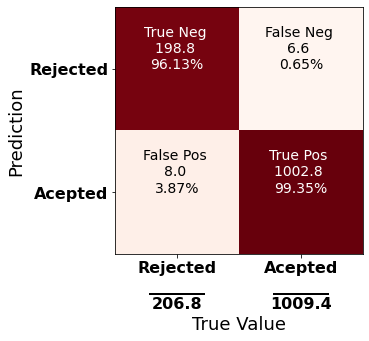

In [20]:
print('Cross validation accuracy GRU net: %.3f (%.3f)' % (np.mean(acc_list), np.std(acc_list)))
print('Cross validation balanced accuracy GRU net: %.3f (%.3f)' % (np.mean(bacc_list), np.std(bacc_list)))
print('Cross validation f1-score GRU net: %.3f (%.3f)' % (np.mean(f1_list), np.std(f1_list)))
class_names = np.array(['Rejected', 'Acepted'])
cfm_avg = np.mean(cf_matrices, axis=0)
plot_confusion_matrix(cfm_avg, classes=class_names, title='Matriz de confusion')

In [8]:
model.save('models/bigru_model_v3_1.h5')